# Importing libraries and all datasets

In [625]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

In [626]:
%matplotlib inline

In [627]:
train = pd.read_csv('Train.csv')
test = pd.read_csv('test_l0Auv8Q.csv')

#Importing all other datasets that we will be merging with the base train and test tables 

first_camp = pd.read_csv('First_Health_Camp_Attended.csv')
second_camp = pd.read_csv('Second_Health_Camp_Attended.csv')
third_camp = pd.read_csv('Third_Health_Camp_Attended.csv')
camp_details = pd.read_csv('Health_Camp_Detail.csv')
patient_profile = pd.read_csv('Patient_Profile.csv')

In [628]:
print('train',train.shape)
print()
print('test',test.shape)
print()
print('first camp',first_camp.shape)
print()
print('second camp',second_camp.shape)
print()
print('third camp',third_camp.shape)
print()
print('camp details',camp_details.shape)
print()
print('patient profile',patient_profile.shape)

train (75278, 8)

test (35249, 8)

first camp (6218, 5)

second camp (7819, 3)

third camp (6515, 4)

camp details (65, 6)

patient profile (37633, 11)


In [629]:
print('train',train.columns.to_list())
print()
print('test',test.columns.to_list())
print()
print('first camp',first_camp.columns.to_list())
print()
print('second camp',second_camp.columns.to_list())
print()
print('third camp',third_camp.columns.to_list())
print()
print('camp details',camp_details.columns.to_list())
print()
print('patient profile',patient_profile.columns.to_list())

train ['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5']

test ['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2', 'Var3', 'Var4', 'Var5']

first camp ['Patient_ID', 'Health_Camp_ID', 'Donation', 'Health_Score', 'Unnamed: 4']

second camp ['Patient_ID', 'Health_Camp_ID', 'Health Score']

third camp ['Patient_ID', 'Health_Camp_ID', 'Number_of_stall_visited', 'Last_Stall_Visited_Number']

camp details ['Health_Camp_ID', 'Camp_Start_Date', 'Camp_End_Date', 'Category1', 'Category2', 'Category3']

patient profile ['Patient_ID', 'Online_Follower', 'LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'Income', 'Education_Score', 'Age', 'First_Interaction', 'City_Type', 'Employer_Category']


# Data Pre-Processing

**Roadmap for pre-processing:** 
Here, we have to merge all the tables in such a way that our train and test tables will respectively have the following columns -
1. Data Merging: Patient ID can be used as the primary key to join all the tables together, except to extract camp details we will have to use the camp ID as the foreign key
    - Patient Profile - All variables from the patient profile dataframe
    - First camp details - yes/no, Donation, camp start date, camp end date, category of the camp, Health_score (target variable)
    - Second camp details - yes/no, camp start date, camp end date, category of the camp, Health_score (target variable)
    - Third camp details - yes/no, last stall visited number, number of stalls visited (target variable)
    
2. Treating null values

3. Treating outliers 

and so on..

In [630]:
mergeddf = pd.merge(train,first_camp, on=['Patient_ID','Health_Camp_ID'], how='left')
mergeddf2 = pd.merge(mergeddf,second_camp, on=['Patient_ID','Health_Camp_ID'], how='left')
mergeddf3 = pd.merge(mergeddf2,third_camp, on=['Patient_ID','Health_Camp_ID'], how='left')

In [631]:
train_target = mergeddf3.copy()
train_target.drop(['Donation','Unnamed: 4','Last_Stall_Visited_Number'],axis=1,inplace=True)

train_target['Outcome'] = np.where((train_target['Health_Score']>0) |
                                 (train_target['Health Score']>0) |
                                 (train_target['Number_of_stall_visited']>0), 
                                 1, 0)

train_target.drop(['Health_Score','Health Score','Number_of_stall_visited'],axis=1,inplace=True)

In [632]:
train_target.isna().sum()

Patient_ID             0
Health_Camp_ID         0
Registration_Date    334
Var1                   0
Var2                   0
Var3                   0
Var4                   0
Var5                   0
Outcome                0
dtype: int64

In [633]:
train_target.dropna(axis=0,inplace=True)

**Adding registration month and date column**

In [634]:
#Converting string to date time format
train_target['Registration_Date'] = pd.to_datetime(train_target['Registration_Date'])

train_target['Reg_Month'] = pd.DatetimeIndex(train_target['Registration_Date']).month.astype('object')
train_target['Reg_Day'] = pd.DatetimeIndex(train_target['Registration_Date']).day.astype('object')

**Adding variables from the camp details dataset**

In [635]:
final_train = pd.merge(train_target,camp_details,on='Health_Camp_ID',how='left')

#Converting camp start and end dates to datetime object

final_train['Camp_Start_Date'] = pd.to_datetime(final_train['Camp_Start_Date'])
final_train['Camp_End_Date'] = pd.to_datetime(final_train['Camp_End_Date'])

#Adding month and day columns for camp start and end date
final_train['Campstart_Month'] = pd.DatetimeIndex(final_train['Camp_Start_Date']).month.astype('object')
final_train['Campstart_Day'] = pd.DatetimeIndex(final_train['Camp_Start_Date']).day.astype('object')
final_train['Campend_Month'] = pd.DatetimeIndex(final_train['Camp_End_Date']).month.astype('object')
final_train['Campend_Day'] = pd.DatetimeIndex(final_train['Camp_End_Date']).day.astype('object')

#Adding some more features
final_train['Reg_Camp_gap'] = (final_train['Camp_End_Date'] - final_train['Registration_Date']).astype('str')
final_train['Camp_duration'] = (final_train['Camp_End_Date'] - final_train['Camp_Start_Date']).astype('str')
#Keeping only days
final_train['Reg_Camp_gap'] = final_train['Reg_Camp_gap'].apply(lambda x: str.split(x)[0])
final_train['Camp_duration'] = final_train['Camp_duration'].apply(lambda x: str.split(x)[0])
#Converting it to a continuous numeric variable
final_train['Reg_Camp_gap'] = final_train['Reg_Camp_gap'].astype('int64')
final_train['Camp_duration'] = final_train['Camp_duration'].astype('int64')

**Adding patient profile characteristics**

In [636]:
final_train = final_train.merge(patient_profile,how='left',on='Patient_ID')

profile = ['Online_Follower','LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'Income',
             'Education_Score', 'Age', 'First_Interaction', 'City_Type','Employer_Category']

#Treating missing values
final_train[profile] = final_train[profile].replace(0,np.nan)
final_train[profile] = final_train[profile].replace('None',np.nan)
final_train['Age'] = final_train['Age'].astype('float')
final_train['Age'].fillna(final_train['Age'].mean(),inplace=True)
final_train['City_Type'].fillna('None',inplace=True)
final_train['Income'].fillna(0,inplace=True)

In [637]:
final_train[profile].isna().sum()/final_train.shape[0]*100

Online_Follower      94.434511
LinkedIn_Shared      93.435098
Twitter_Shared       94.701377
Facebook_Shared      94.441183
Income                0.000000
Education_Score      86.819492
Age                   0.000000
First_Interaction     0.000000
City_Type             0.000000
Employer_Category    79.896990
dtype: float64

In [638]:
#Converting first interaction date to datetime object
final_train['First_Interaction'] = pd.to_datetime(final_train['First_Interaction'])

#Adding some more features
final_train['IntReg_Lag'] = (final_train['Registration_Date'] - final_train['First_Interaction']).astype('str')
#Keeping only days
final_train['IntReg_Lag'] = final_train['IntReg_Lag'].apply(lambda x: str.split(x)[0])
#Converting it to a continuous numeric variable
final_train['IntReg_Lag'] = final_train['IntReg_Lag'].astype('int64')

# EDA

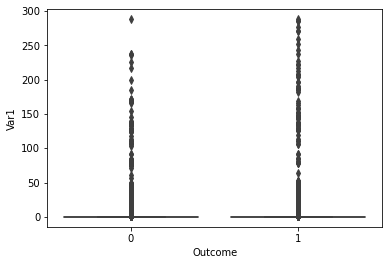

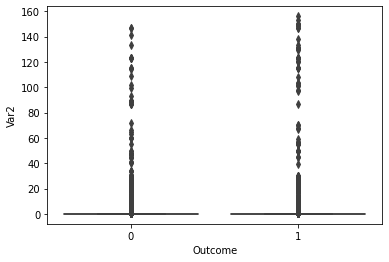

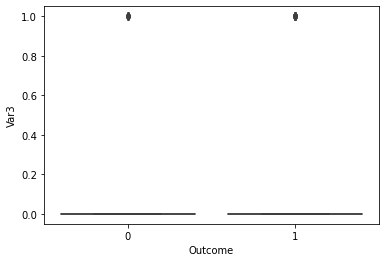

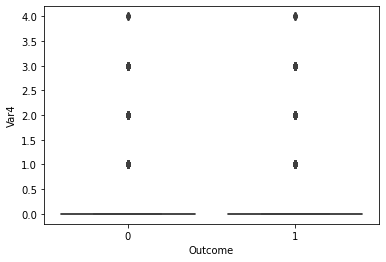

In [639]:
for i in ['Var1','Var2','Var3','Var4']:
    sns.boxplot(x='Outcome',y=i,data=final_train)
    plt.show()

In [640]:
for i in ['Var1','Var2','Var3','Var4']:
    print(final_train[i].skew())

21.92813564151691
28.67491485537422
51.70762834354355
10.760709109861883


Our anonymized variables are largely skewed. Hence, we will have to compulsorily apply a log transformation before we proceed with model training 

# Data Transformation

In [641]:
final_train.columns

Index(['Patient_ID', 'Health_Camp_ID', 'Registration_Date', 'Var1', 'Var2',
       'Var3', 'Var4', 'Var5', 'Outcome', 'Reg_Month', 'Reg_Day',
       'Camp_Start_Date', 'Camp_End_Date', 'Category1', 'Category2',
       'Category3', 'Campstart_Month', 'Campstart_Day', 'Campend_Month',
       'Campend_Day', 'Reg_Camp_gap', 'Camp_duration', 'Online_Follower',
       'LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'Income',
       'Education_Score', 'Age', 'First_Interaction', 'City_Type',
       'Employer_Category', 'IntReg_Lag'],
      dtype='object')

In [642]:
X = final_train[['Var1','Var2','Var5','Reg_Camp_gap','IntReg_Lag','Camp_duration','Age','Category1','Category2']]
y = final_train['Outcome']

In [643]:
col2use = list(X.columns)

In [644]:
X.head()

,Var1,Var2,Var5,Reg_Camp_gap,IntReg_Lag,Camp_duration,Age,Category1,Category2
0,4,0,2,34,278,59,47.914865,Third,G
1,45,5,7,57,344,59,40.000000,Third,G
2,0,0,0,557,676,751,47.914865,Second,A
3,0,0,0,11,0,17,47.914865,First,E
4,15,1,7,34,970,4,40.000000,Second,A


In [645]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 74944 entries, 0 to 74943
Data columns (total 9 columns):
Var1             74944 non-null int64
Var2             74944 non-null int64
Var5             74944 non-null int64
Reg_Camp_gap     74944 non-null int64
IntReg_Lag       74944 non-null int64
Camp_duration    74944 non-null int64
Age              74944 non-null float64
Category1        74944 non-null object
Category2        74944 non-null object
dtypes: float64(1), int64(6), object(2)
memory usage: 8.2+ MB


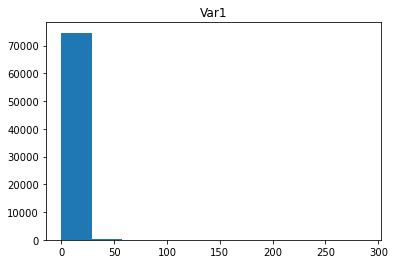

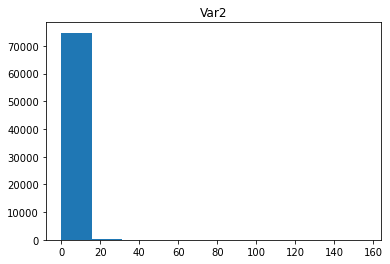

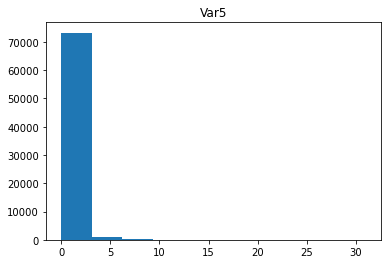

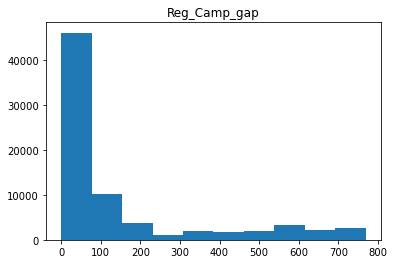

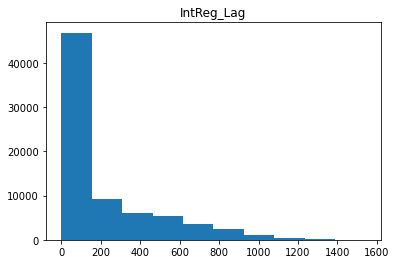

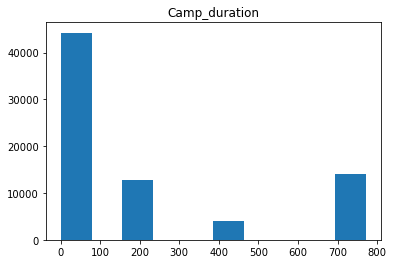

In [646]:
for i in num_cols:
    plt.hist(X[i])
    plt.title(i)
    plt.show()

In [647]:
X = pd.get_dummies(X,drop_first=True)

num_cols = X.select_dtypes(include='int64').columns.to_list()
print(num_cols)

# Log transformation
# for i in num_cols:
#     X[i] = np.log(X[i] + 1)
    
# Normalisation
# from sklearn.preprocessing import StandardScaler
# sc = StandardScaler()
# X[num_cols] = sc.fit_transform(X[num_cols])

['Var1', 'Var2', 'Var5', 'Reg_Camp_gap', 'IntReg_Lag', 'Camp_duration']


### RFC

In [648]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X,y,test_size=0.25,random_state=42)

In [649]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=101)

In [650]:
rf.fit(X_train,y_train)

RandomForestClassifier(random_state=101)

In [651]:
y_pred = rf.predict_proba(X_val)

In [652]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_val,y_pred[:,1])

0.8380285765947231

In [653]:
rffeature_importances = pd.DataFrame(rf.feature_importances_,index = X.columns,
                                   columns=['importance']).sort_values('importance',ascending=False)

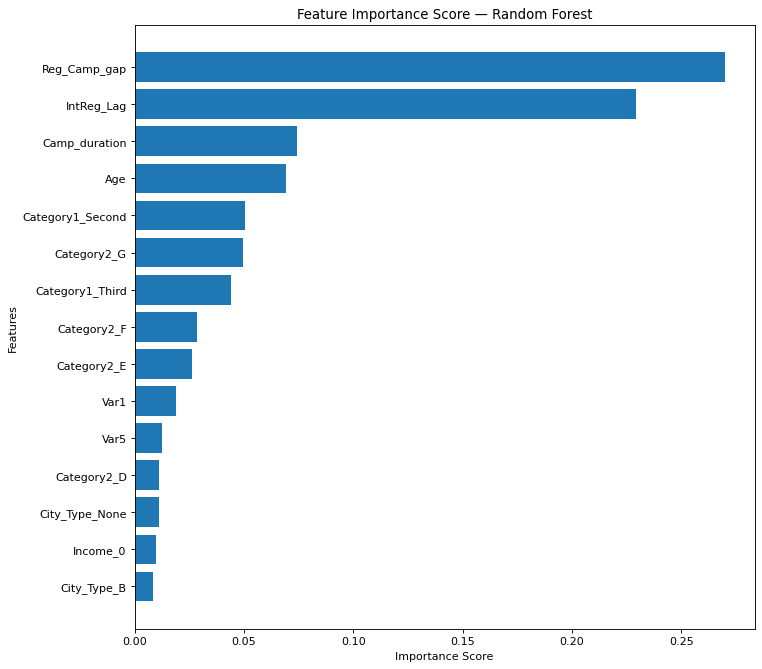

In [654]:
num = min([50,len(list(X.columns))])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = feature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(feature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — Random Forest')
plt.yticks(ylocs, feature_labels)
plt.show()

### XGBC

In [655]:
from xgboost import XGBClassifier
xg = XGBClassifier(random_state=101)

In [656]:
xg.fit(X_train,y_train)
y_pred = xg.predict_proba(X_val)

In [657]:
roc_auc_score(y_val,y_pred[:,1])

0.8430275668169871

In [658]:
xgfeature_importances = pd.DataFrame(xg.feature_importances_,index = X.columns,
                                   columns=['xg_importance']).sort_values('xg_importance',ascending=False)

In [659]:
y_pred_labels = xg.predict(X_val)

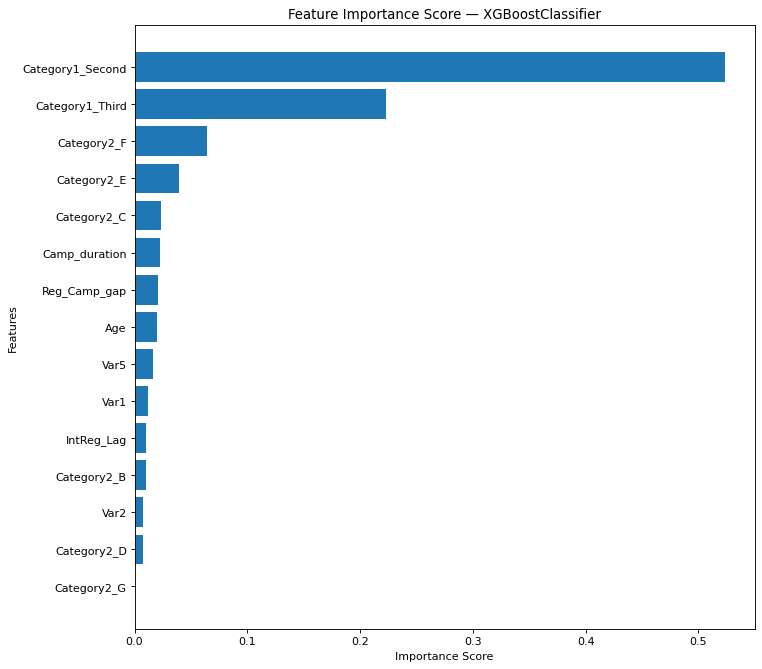

In [660]:
num = min([50,len(list(X.columns))])
ylocs = np.arange(num)
# get the feature importance for top num and sort in reverse order
values_to_plot = xgfeature_importances.iloc[:num].values.ravel()[::-1]
feature_labels = list(xgfeature_importances.iloc[:num].index)[::-1]
plt.figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.barh(ylocs, values_to_plot, align = 'center')
plt.ylabel('Features')
plt.xlabel('Importance Score')
plt.title('Feature Importance Score — XGBoostClassifier')
plt.yticks(ylocs, feature_labels)
plt.show()

# Sample Submission

In [661]:
test.head()

,Patient_ID,Health_Camp_ID,Registration_Date,Var1,Var2,Var3,Var4,Var5
0,505701,6548,21-May-06,1,0,0,0,2
1,500633,6584,02-Jun-06,0,0,0,0,0
2,506945,6582,10-Aug-06,0,0,0,0,0
3,497447,6551,27-Aug-06,0,0,0,0,0
4,496446,6533,19-Sep-06,0,0,0,0,0


In [662]:
col2use

['Var1',
 'Var2',
 'Var5',
 'Reg_Camp_gap',
 'IntReg_Lag',
 'Camp_duration',
 'Age',
 'Category1',
 'Category2']

In [670]:
#Converting string to date time format
test['Registration_Date'] = pd.to_datetime(test['Registration_Date'])

# test['Reg_Month'] = pd.DatetimeIndex(test['Registration_Date']).month.astype('object')
# test['Reg_Day'] = pd.DatetimeIndex(test['Registration_Date']).day.astype('object')

final_test = pd.merge(test,camp_details,on='Health_Camp_ID',how='left')

#Camp-related attributes
#Converting camp start and end dates to datetime object
final_test['Camp_Start_Date'] = pd.to_datetime(final_test['Camp_Start_Date'])
final_test['Camp_End_Date'] = pd.to_datetime(final_test['Camp_End_Date'])

#Adding month and day columns for camp start and end date
# final_test['Campstart_Month'] = pd.DatetimeIndex(final_test['Camp_Start_Date']).month.astype('object')
# final_test['Campstart_Day'] = pd.DatetimeIndex(final_test['Camp_Start_Date']).day.astype('object')
# final_test['Campend_Month'] = pd.DatetimeIndex(final_test['Camp_End_Date']).month.astype('object')
# final_test['Campend_Day'] = pd.DatetimeIndex(final_test['Camp_End_Date']).day.astype('object')

#Adding some more features
final_test['Reg_Camp_gap'] = (final_test['Camp_End_Date'] - final_test['Registration_Date']).astype('str')
final_test['Camp_duration'] = (final_test['Camp_End_Date'] - final_test['Camp_Start_Date']).astype('str')
#Keeping only days
final_test['Reg_Camp_gap'] = final_test['Reg_Camp_gap'].apply(lambda x: str.split(x)[0])
final_test['Camp_duration'] = final_test['Camp_duration'].apply(lambda x: str.split(x)[0])
#Converting it to a continuous numeric variable
final_test['Reg_Camp_gap'] = final_test['Reg_Camp_gap'].astype('int64')
final_test['Camp_duration'] = final_test['Camp_duration'].astype('int64')

#Patient-related attributes
final_test = final_test.merge(patient_profile,how='left',on='Patient_ID')

profile = ['Online_Follower','LinkedIn_Shared', 'Twitter_Shared', 'Facebook_Shared', 'Income',
             'Education_Score', 'Age', 'First_Interaction', 'City_Type','Employer_Category']

print(final_test.isna().sum())

#Treating missing values
final_test[profile] = final_test[profile].replace(0,np.nan)
final_test[profile] = final_test[profile].replace('None',np.nan)
final_test['Age'] = final_test['Age'].astype('float')

print(final_test.isna().sum())

final_test['Age'].fillna(final_train['Age'].mean(),inplace=True)
final_test['City_Type'].fillna('None',inplace=True)
final_test['Income'].fillna(0,inplace=True)

#Converting first interaction date to datetime object
final_test['First_Interaction'] = pd.to_datetime(final_test['First_Interaction'])

#Adding some more features
final_test['IntReg_Lag'] = (final_test['Registration_Date'] - final_test['First_Interaction']).astype('str')
#Keeping only days
final_test['IntReg_Lag'] = final_test['IntReg_Lag'].apply(lambda x: str.split(x)[0])
#Converting it to a continuous numeric variable
final_test['IntReg_Lag'] = final_test['IntReg_Lag'].astype('int64')

#Selecting variables for final run
X_test = final_test[col2use]

#Converting categorical vars to dummy variables
# print(X_test.dtypes)
X_test = pd.get_dummies(X_test,drop_first=True)

#Log transformation
# for i in num_cols:
#     X_test[i] = np.log(X_test[i] + 1)
    
#Normalisation
# X_test[num_cols] = sc.transform(X_test[num_cols])

Patient_ID               0
Health_Camp_ID           0
Registration_Date        0
Var1                     0
Var2                     0
Var3                     0
Var4                     0
Var5                     0
Camp_Start_Date          0
Camp_End_Date            0
Category1                0
Category2                0
Category3                0
Reg_Camp_gap             0
Camp_duration            0
Online_Follower          0
LinkedIn_Shared          0
Twitter_Shared           0
Facebook_Shared          0
Income                   0
Education_Score          0
Age                      0
First_Interaction        0
City_Type            13394
Employer_Category    30888
dtype: int64
Patient_ID               0
Health_Camp_ID           0
Registration_Date        0
Var1                     0
Var2                     0
Var3                     0
Var4                     0
Var5                     0
Camp_Start_Date          0
Camp_End_Date            0
Category1                0
Category2      

In [671]:
print(X_test.shape,X.shape)

missing_cols = set(X.columns) - set(X_test.columns)
for c in missing_cols:
    X_test[c] = 0

print(X_test.shape,X.shape)

#keeping the order of columns same for X and X_test
X_test = X_test[X.columns] 

(35249, 14) (74944, 15)
(35249, 15) (74944, 15)


In [678]:
X_test.head()

,Var1,Var2,Var5,Reg_Camp_gap,IntReg_Lag,Camp_duration,Age,Category1_Second,Category1_Third,Category2_B,Category2_C,Category2_D,Category2_E,Category2_F,Category2_G
0,1,0,2,89,1201,66,44.000000,0,1,0,0,0,0,0,1
1,0,0,0,68,538,5,41.000000,1,0,0,0,0,0,0,0
2,0,0,0,454,113,580,47.914865,0,0,0,0,0,0,1,0
3,0,0,0,83,2,5,47.000000,1,0,0,0,1,0,0,0
4,0,0,0,4,0,3,47.914865,0,0,0,0,0,1,0,0


In [694]:
y_sample_pred = xg.predict_proba(X_test)[:,1]

In [695]:
y_sample_pred

array([0.54916334, 0.35958177, 0.14597665, ..., 0.26709846, 0.30894795,
       0.45229307], dtype=float32)

In [696]:
y_sample_pred = pd.DataFrame(y_sample_pred,columns=['Outcome'])
y_sample_pred['Patient_ID'] = test['Patient_ID']
y_sample_pred['Health_Camp_ID'] = test['Health_Camp_ID']
y_sample_pred

,Outcome,Patient_ID,Health_Camp_ID
0,0.549163,505701,6548
1,0.359582,500633,6584
2,0.145977,506945,6582
3,0.277516,497447,6551
4,0.059709,496446,6533
...,...,...,...
35244,0.507894,507261,6525
35245,0.340792,513607,6551
35246,0.267098,498160,6584
35247,0.308948,502444,6567


In [697]:
submission_v3 = y_sample_pred[['Patient_ID','Health_Camp_ID','Outcome']]
submission_v3

,Patient_ID,Health_Camp_ID,Outcome
0,505701,6548,0.549163
1,500633,6584,0.359582
2,506945,6582,0.145977
3,497447,6551,0.277516
4,496446,6533,0.059709
...,...,...,...
35244,507261,6525,0.507894
35245,513607,6551,0.340792
35246,498160,6584,0.267098
35247,502444,6567,0.308948


In [698]:
submission_v3.to_csv('sample_submission(6).csv',index=False)